# Machine Learning Compilation for Beginners

## Tutorial Overview

Demo: Dr Dignity (Local Models are Private, Data Compliant, &Free (No OpenAI)
1. Build a Simple Language Model in Python!
2. Accelerate on NVIDIA GPUs using Compiler #1: CUDA
3. Accelerate on iOS GPUs using Compiler #2: Metal
4. Accelerate on Android GPUs using Compiler #3: Vulkan
5. Accelerate on iOS & Android GPUs using Compiler #4: Tensor Virtual Machine
6. Compile a Large Language Model from HuggingFace to iOS & Android with TVM
7. Future Directions




## Dependencies

- Python for Programming
- Numpy for CPU speed up
- CUDA for Nvidia GPU speed up
- Metal for iOS GPU speed up
- Vulkan for Android GPU speed up
- Tensor Virtual Machine for iOS and Android GPU speed up
- Relay to Optimize for iOS and Android
- MLC-LLM for LLM-specific Compilation Tools





In [ ]:
!pip install pycuda #CUDA, use an a100 instance
!sudo apt install -y libvulkan-dev #Vulkan
!pip install apache-tvm #Tensor Virtual Machine
!pip install -I mlc_ai_nightly -f https://mlc.ai/wheels #MLC-LLM

Looking in links: https://mlc.ai/wheels
  Using cached https://github.com/mlc-ai/package/releases/download/v0.9.dev0/mlc_ai_nightly-0.12.dev1576-cp310-cp310-manylinux_2_28_x86_64.whl (86.3 MB)
  Using cached attrs-23.1.0-py3-none-any.whl (61 kB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached decorator-5.1.1-py3-none-any.whl (9.1 kB)
  Using cached ml_dtypes-0.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached numpy-1.26.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Using cached psutil-5.9.5-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (282 kB)
  Using cached scipy-1.11.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.3 MB)
  Using cached tornado-6.3.3-cp38-abi3-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (427 kB)
  Using cached typing_extensions-4.8.0-py3-none-any.whl (31 kB)
ERROR: pip'

## Step 1 - Build a Simple Language Model in Python!


- This Model aims to predict the next character in the sequence based on the current character.
- The model is trained on a dataset of individual characters ('a', 'b', 'c', 'd', 'e')
- This is a one-hot encoded character prediction model.
- ![Alt Text](https://miro.medium.com/v2/resize:fit:714/0*TsV7C_p9Yhkeqthg.png)
- ![Alt Text](https://raw.githubusercontent.com/geekquad/deep-learning-v2-pytorch/master/recurrent-neural-networks/char-rnn/assets/charseq.jpeg)






In [ ]:
# Import the NumPy library for numerical computations
import numpy as np

# ---- Data and Parameters ----

# Initialize the data as a string "abcde"
data = "abcde"
# Create a dictionary to map each unique character in the data to an index
vocab = {c: i for i, c in enumerate(set(data))}
# Create an inverse dictionary to map each index back to its corresponding character
inv_vocab = {i: c for c, i in vocab.items()}
# Initialize the weight matrix with random values; its dimensions are based on the vocabulary size
w = np.random.rand(len(vocab), len(vocab))
# Set the learning rate for the model
lr = 0.1

# ---- Data Preprocessing ----

# Convert each character in the data to its corresponding numerical index
data_idx = [vocab[c] for c in data]

# ---- Training Loop ----

# Loop through the data (ignoring the last character)
for i in range(len(data_idx) - 1):
    # Extract the current and next characters' indices
    x, y = data_idx[i], data_idx[i + 1]
    # Generate a one-hot encoded vector for the current character
    x_onehot = np.eye(len(vocab))[x]

    # ---- Forward Pass ----

    # Compute the dot product of the one-hot vector and the weight matrix, then apply the exponential function
    pred = np.exp(np.dot(x_onehot, w))
    # Normalize the resulting vector to form a probability distribution
    pred /= np.sum(pred)

    # ---- Loss and Gradient Calculation ----

    # Compute the negative log-likelihood loss
    loss = -np.log(pred[y])
    # Compute the gradient based on the difference between the predicted and actual distributions
    grad = pred - np.eye(len(vocab))[y]

    # ---- Weight Update ----

    # Update the weight matrix using stochastic gradient descent
    w[:, x] -= lr * grad

# ---- Inference ----

# Set the input character for prediction
input_char = 'a'
# Convert the input character to its corresponding numerical index
input_idx = vocab[input_char]
# Generate a one-hot encoded vector for the input character
input_onehot = np.eye(len(vocab))[input_idx]
# Perform the forward pass to get the output probabilities
output_prob = np.exp(np.dot(input_onehot, w))
# Normalize the output probabilities
output_prob /= np.sum(output_prob)
# Find the index of the character with the highest predicted probability
output_idx = np.argmax(output_prob)
# Use the inverse vocabulary to map the index back to a character
output_char = inv_vocab[output_idx]

# Print the predicted next character given the input
print(f"Given '{input_char}', next predicted character is '{output_char}'")


Given 'a', next predicted character is 'c'


### Measure Inference Speed on Intel CPU

- CPU cycle
- ![Alt Text](https://www.computerhope.com/jargon/m/machine-cycle.png)
- In a CPU, the memory hierarchy includes multiple levels of cache to store data temporarily for time, space, & power efficiency.
- Full Data Flow below
- ![Alt Text](https://anilmaurya.files.wordpress.com/2016/02/cpu-block-diagram.gif)


In [ ]:
# Import the 'time' library for timing operations
import time
# Import the 'numpy' library for numerical operations
import numpy as np

# Initialize an empty list to store the time taken for each inference operation
times = []

# Loop to run the inference process 1000 times
for _ in range(1000):
    # Record the start time before running inference
    start = time.time()

    # Create a one-hot encoded input array for inference (here, the first element is 1 and the rest are 0)
    input_onehot = np.eye(5)[0]

    # Perform the forward pass: dot product of the one-hot input with a random weight matrix, followed by exponentiation
    output_prob = np.exp(np.dot(input_onehot, np.random.rand(5, 5)))

    # Normalize the output to get a probability distribution
    output_prob /= np.sum(output_prob)

    # Record the time taken for this inference operation
    elapsed_time = time.time() - start

    # Append the elapsed time to the 'times' list
    times.append(elapsed_time)

# Calculate the average time taken for inference across all runs, and convert it to milliseconds
average_time = np.mean(times) * 1000

# Print the average inference time, rounded to 2 decimal places
print(f"Average Inference Time: {average_time:.2f} ms")

Average Inference Time: 0.07 ms


## Step 2 - Accelerate on NVIDIA GPUs using Compiler #1: CUDA


- ![Alt Text](https://data.embeddedcomputing.com/uploads/articles/wp/1462/54176dc2ec16c-Vivante-Sept-Fig1.jpg)
- ![Alt Text](https://pbs.twimg.com/media/EbxlFreUwAAZ2sZ?format=jpg&name=900x900)
- ![Alt Text](https://www.researchgate.net/profile/Joshua-Payne-2/publication/265291072/figure/fig1/AS:650829417680896@1532181233055/Performance-comparison-of-GPUs-vs-CPUs.png)
- ![Alt Text](http://2.bp.blogspot.com/-UHviPBWWhR8/UPWSIVXHmLI/AAAAAAAAAsU/3gi4jAAtSIU/s1600/compilation.png)
- CUDA tutorial https://web.engr.oregonstate.edu/~mjb/cs575/Handouts/cuda.1pp.pdf





In [ ]:
# Import the CUDA driver interface from the PyCUDA library
import pycuda.driver as cuda
# Initialize the PyCUDA library
import pycuda.autoinit
# Import the SourceModule for compiling CUDA source code
from pycuda.compiler import SourceModule
# Import NumPy for numerical operations
import numpy as np
# Import time for timing the code
import time

# Define a vocabulary list
vocab = ['a', 'b', 'c', 'd', 'e']

# Define the CUDA kernel function for inference as a string
mod = SourceModule("""
  __global__ void inference(float *x, float *w, float *y, int vocab_size)
  {
    const int i = threadIdx.x;  // Get the thread index
    float sum = 0;  // Initialize sum variable

    // Loop to calculate the sum of element-wise products of 'x' and 'w'
    for(int j = 0; j < vocab_size; j++)
    {
        sum += exp(w[j * vocab_size + i] * x[j]);  // Exponential function applied to the element-wise product
    }

    // Store the sum in the output array 'y'
    y[i] = sum;
  }
""")

# Define the size of the vocabulary
vocab_size = 5
# Generate random weights and cast them to float32
w = np.random.rand(vocab_size, vocab_size).astype(np.float32)
# Create a one-hot vector representation for the first element 'a' in the vocabulary
x_onehot = np.eye(vocab_size, dtype=np.float32)[0]  # One-hot vector for 'a'

# Allocate GPU memory for weight, input, and output arrays
w_gpu = cuda.mem_alloc(w.nbytes)
x_gpu = cuda.mem_alloc(x_onehot.nbytes)
y_gpu = cuda.mem_alloc(vocab_size * 4)  # 4 bytes for each float32 element

# Copy data from host to device (CPU to GPU)
cuda.memcpy_htod(w_gpu, w)
cuda.memcpy_htod(x_gpu, x_onehot)


### Measure Inference Speed on Nvidia GPU

In [ ]:
# Retrieve the compiled CUDA kernel function named "inference"
func = mod.get_function("inference")
# Record the starting time for timing the execution
start_time = time.time()

# Execute the CUDA kernel function 1000 times
for _ in range(1000):
    # Run the CUDA function with the given parameters and thread configuration
    func(x_gpu, w_gpu, y_gpu, np.int32(vocab_size), block=(vocab_size, 1, 1))

# Synchronize the CUDA context to ensure all operations are complete
cuda.Context.synchronize()
# Record the ending time to calculate the elapsed time
end_time = time.time()

# Create an empty NumPy array with the same shape as x_onehot to store results
y = np.empty_like(x_onehot)
# Copy the result from GPU to CPU (device to host)
cuda.memcpy_dtoh(y, y_gpu)
# Apply the exponential function to the result to undo the previous log operation
y = np.exp(y)
# Normalize the probabilities so they sum to 1
y /= np.sum(y)

# Find the index of the maximum value in the array 'y'
predicted_index = np.argmax(y)

# Print the calculated probabilities
print(f"Predicted probabilities: {y}")
# Print the most probable next character based on the given input 'a'
print(f"Given 'a', the next predicted character is: '{vocab[predicted_index]}'")
# Print the average time taken for inference
print(f"Average Inference Time: {(end_time - start_time) / 1000 * 1000:.2f} ms")


Predicted probabilities: [0.14863102 0.15203634 0.15777873 0.310623   0.23093095]
Given 'a', the next predicted character is: 'd'
Average Inference Time: 0.01 ms


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()


## Step 3 - Accelerate on iOS GPUs using Compiler #2: Metal


- There are many GPU providers, not just Nvidia
- ![Alt Text](https://i.ytimg.com/vi/6GOzFB7bAqg/sddefault.jpg)
- Apple has it's A Series Chips
- ![Alt Text](https://static.wikia.nocookie.net/ipod/images/8/8d/Apple_A15_simplified_schematic_parts.jpg/revision/latest?cb=20220911035113)
- The Metal Compiler lets us leverage it
- ![Alt Text](https://devimages-cdn.apple.com/wwdc-services/images/124/6556/6556_wide_250x141_2x.jpg)




Time to leave Colab...sorry, not sorry Nvidia.

1. Open Xcode
2. Create a new command-line project
3. Paste the below inference function into it
4. Create a .metal file
7. Replace the .metal reference directory with the second cell block
8. Build and run the project!

Language model in Objective-C

```objective-c

#import <Foundation/Foundation.h>
#import <Metal/Metal.h>

#import <math.h>

@interface SimpleLanguageModel : NSObject

@property float *w;
@property float lr;
@property NSDictionary *vocab;
@property NSDictionary *inv_vocab;
@property NSUInteger vocabSize;

- (instancetype)initWithData:(NSString *)data learningRate:(float)lr;
- (void)train;
- (NSString *)predictNextCharacter:(NSString *)inputChar;

@end

@implementation SimpleLanguageModel

- (instancetype)initWithData:(NSString *)data learningRate:(float)lr {
    self = [super init];
    if (self) {
        self.lr = lr;
        self.vocab = [self buildVocab:data];
        self.inv_vocab = [self buildInvVocab:self.vocab];
        self.vocabSize = [self.vocab count];
        self.w = malloc(self.vocabSize * self.vocabSize * sizeof(float));
        for (int i = 0; i < self.vocabSize * self.vocabSize; i++) {
            self.w[i] = ((float)rand() / RAND_MAX);
        }
    }
    return self;
}

- (NSDictionary *)buildVocab:(NSString *)data {
    NSMutableDictionary *vocab = [NSMutableDictionary dictionary];
    for (int i = 0; i < [data length]; i++) {
        NSString *charStr = [NSString stringWithFormat:@"%C", [data characterAtIndex:i]];
        [vocab setObject:[NSNumber numberWithInt:i] forKey:charStr];
    }
    return [vocab copy];
}

- (NSDictionary *)buildInvVocab:(NSDictionary *)vocab {
    NSMutableDictionary *inv_vocab = [NSMutableDictionary dictionary];
    for (NSString *key in vocab) {
        inv_vocab[vocab[key]] = key;
    }
    return [inv_vocab copy];
}

- (void)train {
    NSArray *data = @[@0, @1, @2, @3, @4];  // Assuming the vocab indices are from 0 to 4
    
    for (NSNumber *x in data) {
        NSNumber *y = [data objectAtIndex:([data indexOfObject:x] + 1) % [data count]];
        
        float pred[self.vocabSize];
        for (int i = 0; i < self.vocabSize; i++) {
            pred[i] = exp(self.w[i * self.vocabSize + [x intValue]]);
        }
        float sumPred = 0;
        for (int i = 0; i < self.vocabSize; i++) {
            sumPred += pred[i];
        }
        for (int i = 0; i < self.vocabSize; i++) {
            pred[i] /= sumPred;
        }
        
        float loss = -log(pred[[y intValue]]);
        NSLog(@"Loss: %f", loss);
        
        float grad[self.vocabSize];
        for (int i = 0; i < self.vocabSize; i++) {
            grad[i] = pred[i] - (i == [y intValue] ? 1 : 0);
        }
        
        for (int i = 0; i < self.vocabSize; i++) {
            self.w[i * self.vocabSize + [x intValue]] -= self.lr * grad[i];
        }
    }
}

- (NSString *)predictNextCharacter:(NSString *)inputChar {
    int inputIdx = [[self.vocab objectForKey:inputChar] intValue];
    
    float output_prob[self.vocabSize];
    for (int i = 0; i < self.vocabSize; i++) {
        output_prob[i] = exp(self.w[i * self.vocabSize + inputIdx]);
    }
    
    float sumProb = 0;
    for (int i = 0; i < self.vocabSize; i++) {
        sumProb += output_prob[i];
    }
    for (int i = 0; i < self.vocabSize; i++) {
        output_prob[i] /= sumProb;
    }
    
    int outputIdx = 0;
    float maxProb = 0;
    for (int i = 0; i < self.vocabSize; i++) {
        if (output_prob[i] > maxProb) {
            maxProb = output_prob[i];
            outputIdx = i;
        }
    }
    
    return [self.inv_vocab objectForKey:[NSNumber numberWithInt:outputIdx]];
}

@end


int main(int argc, const char * argv[]) {
    @autoreleasepool {
        
        id<MTLDevice> device = MTLCreateSystemDefaultDevice();
        NSError *error = nil;
        
        NSString *metalSrc = [NSString stringWithContentsOfFile:@"/Users/sirajraval/Desktop/metal_test/metal_test/fun.metal" encoding:NSUTF8StringEncoding error:&error];
        id<MTLLibrary> library = [device newLibraryWithSource:metalSrc options:nil error:&error];
        
        id<MTLFunction> function = [library newFunctionWithName:@"predict_next_character"];
        id<MTLComputePipelineState> pipelineState = [device newComputePipelineStateWithFunction:function error:&error];
        
        id<MTLCommandQueue> commandQueue = [device newCommandQueue];
        id<MTLCommandBuffer> commandBuffer = [commandQueue commandBuffer];
        id<MTLComputeCommandEncoder> commandEncoder = [commandBuffer computeCommandEncoder];
        
        [commandEncoder setComputePipelineState:pipelineState];
        
        SimpleLanguageModel *model = [[SimpleLanguageModel alloc] initWithData:@"abcde" learningRate:0.1];
        
        // Convert your weights to an MTLBuffer (in this example, I'm assuming the weights are a 5x5 matrix)
        id<MTLBuffer> weightBuffer = [device newBufferWithBytes:model.w length:25*sizeof(float) options:MTLResourceStorageModeShared];
        
        float input_onehot[] = {1.0, 0.0, 0.0, 0.0, 0.0};  // Assume 'a' is encoded as this one-hot vector
        id<MTLBuffer> inputBuffer = [device newBufferWithBytes:input_onehot length:5*sizeof(float) options:MTLResourceStorageModeShared];
        
        float output_prob[5] = {0};
        id<MTLBuffer> outputBuffer = [device newBufferWithBytes:output_prob length:5*sizeof(float) options:MTLResourceStorageModeShared];
        
        [commandEncoder setBuffer:weightBuffer offset:0 atIndex:0];
        [commandEncoder setBuffer:inputBuffer offset:0 atIndex:1];
        [commandEncoder setBuffer:outputBuffer offset:0 atIndex:2];
        
        MTLSize gridSize = MTLSizeMake(5, 1, 1);
        MTLSize threadGroupSize = MTLSizeMake(1, 1, 1);
        
        [commandEncoder dispatchThreadgroups:gridSize threadsPerThreadgroup:threadGroupSize];
        
        [commandEncoder endEncoding];
        [commandBuffer commit];
        


               
        
        
        [commandBuffer waitUntilCompleted];
        
        memcpy(output_prob, [outputBuffer contents], sizeof(output_prob));
        
        // Sum up all the probabilities to normalize them
        double sum = 0.0;
        for (int i = 0; i < model.vocabSize; i++) {
            sum += output_prob[i];
        }

        // Normalize each output probability
        for (int i = 0; i < model.vocabSize; i++) {
            output_prob[i] /= sum;
        }

        // Find the index of the most likely next character
        int maxIndex = 0;
        double maxProb = 0.0;
        for (int i = 0; i < model.vocabSize; i++) {
            if (output_prob[i] > maxProb) {
                maxProb = output_prob[i];
                maxIndex = i;
            }
        }

        // Convert the index back to a character
        NSString *nextChar = [model.inv_vocab objectForKey:[NSNumber numberWithInt:maxIndex]];

        NSLog(@"Given '%s', the next predicted character is '%@'", "a", nextChar);
        

        NSDate *startTime = [NSDate date];  // Capture the start time
        NSString *nexty = [model predictNextCharacter:@"a"];
        NSDate *endTime = [NSDate date];  // Capture the end time
        NSTimeInterval timeInterval = [endTime timeIntervalSinceDate:startTime];

        NSLog(@"Inference took %f milliseconds", timeInterval*1000);


    }
    return 0;
}

```

Metal Code for Inference Speed Up on Apple GPUs

```objective-c
#include <metal_stdlib>
using namespace metal;

kernel void predict_next_character(
    constant float *weights [[buffer(0)]],
    device float *input_onehot [[buffer(1)]],
    device float *output_prob [[buffer(2)]],
    uint id [[thread_position_in_grid]]
) {
    float prob = 0.0;
    for (uint i = 0; i < 5; ++i) {
        prob += weights[id * 5 + i] * input_onehot[i];
    }
    output_prob[id] = exp(prob);
}

```

## Step 4 - Accelerate on Android GPUs using Compiler #3: Vulkan

- Most Phones use Android
- ![Alt Text](https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEjV3ABZMrT-oJ3vcUTwJr6xp4FKwyD0Gg2f6ZayIDpP9HyXDyWtq0nPZVVF0zye4gAr-OU-2ehNdJTpJ7b9no2Ebj7TMcHsoz72LKewuC5Y4IEbH_ghFFuFhtYn_GohJQcKbDbuubXEESwwBPaLxzk4CT7GnjfcE5hwTZxav6ekTvMck09Rc8ccRASp/s2092/os-market-share.png)

- Lots of Different GPU vendors in the Android Ecosystem

- ![Alt Text](https://www.techspot.com/images2/news/bigimage/2020/12/2020-12-26-image-2.png)

Vulkan is the best API, it's a successor to OpenGL

- ![Alt Text](https://i.ytimg.com/vi/rvCD9FaTKCA/maxresdefault.jpg)
- ![Alt Text](https://architosh.com/wp-content/uploads/2015/03/opengl-v-vulkan.jpg)

- ![Alt Text](https://registry.khronos.org/vulkan/site/guide/latest/_images/platforms_overview.png)

- Let's leverage the video memory, the vRAM

- ![Alt Text](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Division_of_labor_cpu_and_gpu.svg/500px-Division_of_labor_cpu_and_gpu.svg.png)




```c
%%writefile vulkan.cpp


#include <iostream>
#include <fstream>
#include <unordered_map>
#include <vector>
#include <cmath>
#include <numeric>
#include <algorithm>
#include <chrono>  
#include <vulkan/vulkan.h>



VkInstance instance;
VkPhysicalDevice physicalDevice;
VkDevice device;
VkPipelineLayout pipelineLayout;
VkCommandPool commandPool;
VkCommandBuffer commandBuffer;
VkPipeline computePipeline;



using namespace std;

void createInstance() {
    VkApplicationInfo appInfo{};
    appInfo.sType = VK_STRUCTURE_TYPE_APPLICATION_INFO;
    appInfo.pApplicationName = "Language Model";
    appInfo.applicationVersion = VK_MAKE_VERSION(1, 0, 0);
    appInfo.pEngineName = "No Engine";
    appInfo.engineVersion = VK_MAKE_VERSION(1, 0, 0);
    appInfo.apiVersion = VK_API_VERSION_1_0;

    VkInstanceCreateInfo createInfo{};
    createInfo.sType = VK_STRUCTURE_TYPE_INSTANCE_CREATE_INFO;
    createInfo.pApplicationInfo = &appInfo;

    if (vkCreateInstance(&createInfo, nullptr, &instance) != VK_SUCCESS) {
        throw std::runtime_error("Failed to create Vulkan instance!");
    }

}

void runComputationOnGPU() {
    // Start recording commands
    VkCommandBufferBeginInfo beginInfo{};
    beginInfo.sType = VK_STRUCTURE_TYPE_COMMAND_BUFFER_BEGIN_INFO;

    if (vkBeginCommandBuffer(commandBuffer, &beginInfo) != VK_SUCCESS) {
        throw std::runtime_error("Failed to begin recording command buffer!");
    }

    // Add your Vulkan compute dispatch command here
    vkCmdBindPipeline(commandBuffer, VK_PIPELINE_BIND_POINT_COMPUTE, computePipeline);
    vkCmdDispatch(commandBuffer, 1, 1, 1);

    // End recording
    if (vkEndCommandBuffer(commandBuffer) != VK_SUCCESS) {
        throw std::runtime_error("Failed to record command buffer!");
    }

    // Submit the command buffer to the queue
    VkSubmitInfo submitInfo{};
    submitInfo.sType = VK_STRUCTURE_TYPE_SUBMIT_INFO;
    submitInfo.commandBufferCount = 1;
    submitInfo.pCommandBuffers = &commandBuffer;

    VkQueue computeQueue;  // Should be initialized properly
    if (vkQueueSubmit(computeQueue, 1, &submitInfo, VK_NULL_HANDLE) != VK_SUCCESS) {
        throw std::runtime_error("Failed to submit command buffer!");
    }

    vkQueueWaitIdle(computeQueue);  // Ensure the computation is finished
}


void pickPhysicalDevice() {
    uint32_t deviceCount = 0;
    vkEnumeratePhysicalDevices(instance, &deviceCount, nullptr);

    if (deviceCount == 0) {
        throw std::runtime_error("Failed to find GPUs with Vulkan support!");
    }

    std::vector<VkPhysicalDevice> devices(deviceCount);
    vkEnumeratePhysicalDevices(instance, &deviceCount, devices.data());

    for (const auto& dev : devices) {
        if (true /* Here we can put conditions for picking the best device */) {
            physicalDevice = dev;
            break;
        }
    }

    if (physicalDevice == VK_NULL_HANDLE) {
        throw std::runtime_error("Failed to find a suitable GPU!");
    }
}

void createLogicalDevice() {
    VkDeviceQueueCreateInfo queueCreateInfo{};
    queueCreateInfo.sType = VK_STRUCTURE_TYPE_DEVICE_QUEUE_CREATE_INFO;
    queueCreateInfo.queueFamilyIndex = 0; // Should be determined properly
    queueCreateInfo.queueCount = 1;

    float queuePriority = 1.0f;
    queueCreateInfo.pQueuePriorities = &queuePriority;

    VkDeviceCreateInfo deviceInfo{};
    deviceInfo.sType = VK_STRUCTURE_TYPE_DEVICE_CREATE_INFO;
    deviceInfo.pQueueCreateInfos = &queueCreateInfo;
    deviceInfo.queueCreateInfoCount = 1;

    VkPhysicalDeviceFeatures deviceFeatures{};
    deviceInfo.pEnabledFeatures = &deviceFeatures;

    if (vkCreateDevice(physicalDevice, &deviceInfo, nullptr, &device) != VK_SUCCESS) {
        throw std::runtime_error("Failed to create logical device!");
    }
}

void createCommandPool() {
    VkCommandPoolCreateInfo poolInfo{};
    poolInfo.sType = VK_STRUCTURE_TYPE_COMMAND_POOL_CREATE_INFO;
    poolInfo.queueFamilyIndex = 0;  // Should be determined properly

    if (vkCreateCommandPool(device, &poolInfo, nullptr, &commandPool) != VK_SUCCESS) {
        throw std::runtime_error("Failed to create command pool!");
    }
}


void createCommandBuffer() {
    VkCommandBufferAllocateInfo allocInfo{};
    allocInfo.sType = VK_STRUCTURE_TYPE_COMMAND_BUFFER_ALLOCATE_INFO;
    allocInfo.commandPool = commandPool;
    allocInfo.level = VK_COMMAND_BUFFER_LEVEL_PRIMARY;
    allocInfo.commandBufferCount = 1;

    if (vkAllocateCommandBuffers(device, &allocInfo, &commandBuffer) != VK_SUCCESS) {
        throw std::runtime_error("Failed to allocate command buffer!");
    }
}


VkBuffer createBuffer(VkDevice device, VkPhysicalDevice physicalDevice, VkDeviceSize size, VkBufferUsageFlags usage) {
    VkBufferCreateInfo bufferInfo{};
    bufferInfo.sType = VK_STRUCTURE_TYPE_BUFFER_CREATE_INFO;
    bufferInfo.size = size;
    bufferInfo.usage = usage;
    bufferInfo.sharingMode = VK_SHARING_MODE_EXCLUSIVE;

    VkBuffer buffer;
    if (vkCreateBuffer(device, &bufferInfo, nullptr, &buffer) != VK_SUCCESS) {
        throw std::runtime_error("Failed to create buffer.");
    }

    return buffer;
}

void copyDataToBuffer(VkDevice device, VkBuffer buffer, void* data, VkDeviceSize size) {
    // Code to map buffer memory and copy data to buffer
    // Implementation can vary based on how you've set up memory
    // Typically you'd use vkMapMemory, memcpy, and vkUnmapMemory
}

void createAndFillBuffer(VkDevice device, VkPhysicalDevice physicalDevice, void* data, VkDeviceSize size, VkBufferUsageFlags usage, VkBuffer& buffer) {
    buffer = createBuffer(device, physicalDevice, size, usage);
    copyDataToBuffer(device, buffer, data, size);
}

VkShaderModule createShaderModule(VkDevice device, const std::vector<char>& code) {
    VkShaderModuleCreateInfo createInfo{};
    createInfo.sType = VK_STRUCTURE_TYPE_SHADER_MODULE_CREATE_INFO;
    createInfo.codeSize = code.size();
    createInfo.pCode = reinterpret_cast<const uint32_t*>(code.data());

    VkShaderModule shaderModule;
    if (vkCreateShaderModule(device, &createInfo, nullptr, &shaderModule) != VK_SUCCESS) {
        throw std::runtime_error("Failed to create shader module");
    }

    return shaderModule;
}

void createShaderModuler()  {


    VkPipelineLayout pipelineLayout;
VkPipelineLayoutCreateInfo pipelineLayoutInfo{};
pipelineLayoutInfo.sType = VK_STRUCTURE_TYPE_PIPELINE_LAYOUT_CREATE_INFO;
pipelineLayoutInfo.setLayoutCount = 0; // Optional
pipelineLayoutInfo.pSetLayouts = nullptr; // Optional
pipelineLayoutInfo.pushConstantRangeCount = 0; // Optional
pipelineLayoutInfo.pPushConstantRanges = nullptr; // Optional

if (vkCreatePipelineLayout(device, &pipelineLayoutInfo, nullptr, &pipelineLayout) != VK_SUCCESS) {
    throw std::runtime_error("Failed to create pipeline layout!");
}

}

std::vector<char> readShaderFile(const std::string& filename) {
    std::ifstream file(filename, std::ios::ate | std::ios::binary);

    if (!file.is_open()) {
        throw std::runtime_error("Failed to open file!");
    }

    size_t fileSize = (size_t) file.tellg();
    std::vector<char> buffer(fileSize);

    file.seekg(0);
    file.read(buffer.data(), fileSize);

    file.close();

    return buffer;
}


void createPipeline()  {

VkPipeline computePipeline;
VkComputePipelineCreateInfo pipelineInfo{};
pipelineInfo.sType = VK_STRUCTURE_TYPE_COMPUTE_PIPELINE_CREATE_INFO;
pipelineInfo.stage.sType = VK_STRUCTURE_TYPE_PIPELINE_SHADER_STAGE_CREATE_INFO;
pipelineInfo.stage.stage = VK_SHADER_STAGE_COMPUTE_BIT;


std::vector<char> shaderCode = readShaderFile("/comp.spv");  // Make sure this path is correct
VkShaderModule shaderModule = createShaderModule(device, shaderCode);

pipelineInfo.stage.module = shaderModule; // The shaderModule you created
pipelineInfo.stage.pName = "main";
pipelineInfo.layout = pipelineLayout;

if (vkCreateComputePipelines(device, VK_NULL_HANDLE, 1, &pipelineInfo, nullptr, &computePipeline) != VK_SUCCESS) {
    throw std::runtime_error("Failed to create compute pipeline!");
}


}


int main() {

      try {
        createInstance();
        pickPhysicalDevice();
        createLogicalDevice();
        createShaderModuler();
        createPipeline();
        createCommandPool();
        createCommandBuffer();
    } catch (const std::exception& e) {
        std::cerr << e.what() << std::endl;
        return EXIT_FAILURE;
    }


    string data = "abcde";
    unordered_map<char, int> vocab;
    unordered_map<int, char> inv_vocab;
    int vocab_size = 0;

    for (char c : data) {
        vocab[c] = vocab_size;
        inv_vocab[vocab_size] = c;
        vocab_size++;
    }

    vector<vector<double>> w(vocab_size, vector<double>(vocab_size, rand() % 100 / 100.0));
    double lr = 0.1;
    vector<int> data_idx;

    for (char c : data) {
        data_idx.push_back(vocab[c]);
    }

    for (int i = 0; i < data_idx.size() - 1; ++i) {
        int x = data_idx[i], y = data_idx[i + 1];
        vector<double> x_onehot(vocab_size, 0);
        x_onehot[x] = 1;

        vector<double> pred(vocab_size);
        for (int j = 0; j < vocab_size; ++j) {
            pred[j] = exp(x_onehot[j] * w[j][x]);
        }

        double sum_pred = accumulate(pred.begin(), pred.end(), 0.0);
        for (double &p : pred) p /= sum_pred;

        double loss = -log(pred[y]);

        vector<double> grad = pred;
        grad[y] -= 1;

        for (int j = 0; j < vocab_size; ++j) {
            w[j][x] -= lr * grad[j];
        }
    }


 // Start timer
    auto start_time = std::chrono::high_resolution_clock::now();

    char input_char = 'a';
    int input_idx = vocab[input_char];
    vector<double> input_onehot(vocab_size, 0);
    input_onehot[input_idx] = 1;

    runComputationOnGPU();
    vector<double> output_prob(vocab_size);
    for (int i = 0; i < vocab_size; ++i) {
        output_prob[i] = exp(input_onehot[i] * w[i][input_idx]);
    }

    double sum_output = accumulate(output_prob.begin(), output_prob.end(), 0.0);
    for (double &p : output_prob) p /= sum_output;

    int output_idx = max_element(output_prob.begin(), output_prob.end()) -
output_prob.begin();
    char output_char = inv_vocab[output_idx];

    // Stop timer and calculate elapsed time in milliseconds
    auto end_time = std::chrono::high_resolution_clock::now();
    auto duration = std::chrono::duration_cast<std::chrono::nanoseconds>(end_time -
start_time).count();

    cout << "Given '" << input_char << "', next predicted character is '" << output_char <<
"'\n";
    cout << "Inference time: " << duration << " nanosecondss\n";
    return 0;
}

```

Run the following 2 commands to compile.

- g++ vulkan.cpp -lvulkan -o vulkan -std=c++11
- !./vulkan

## Step 5 - Accelerate on iOS & Android GPUs using Compiler #4: Tensor Virtual Machine

# Hardware Optimization Strategies for Machine Learning

- There are many ways to make Inference faster.
- Each GPU process data differently.
- Below are some examples

- ![Alt Text](https://ars.els-cdn.com/content/image/1-s2.0-S1383762120301430-gr26.jpg)


## General GPU Optimizations

- **Memory Coalescing**: Structure your memory access patterns to make them contiguous and aligned, reducing memory latency.
  
- **Loop Unrolling**: Reduce the overhead of the loop control code to improve performance.

- **Data Tiling**: Break the data into smaller chunks or "tiles" to fit into faster but smaller memory caches.

- **Vectorization**: Use SIMD (Single Instruction, Multiple Data) operations to process multiple data points in a single instruction.

- **Batching**: Process multiple inputs at the same time to make better use of the hardware.

- **Prefetching**: Manually load data into cache before it's needed to reduce latency.

- **Pipeline Parallelism**: Overlap the execution of independent operations.

---

## CUDA-Specific Optimizations

- **Shared Memory**: Use shared memory to avoid redundant global memory access.

- **Warp Shuffle**: Use warp shuffle functions for faster intra-warp communication.

- **Stream Multiprocessor Occupancy**: Maximize the use of stream multiprocessors for higher throughput.

- **Zero-Copy**: For host-device communication, use zero-copy memory to reduce data transfer times.

---
## Metal-Specific Optimizations

- **Threadgroup Memory**: Use threadgroup shared memory for faster data sharing among threads.

- **Metal Performance Shaders**: Use built-in high-performance shaders for common operations where available.

- **Resource Groups**: Use argument buffers to efficiently manage resources.

- **Half-Precision (fp16)**: Use half-precision floating-point arithmetic where full precision isn't required for performance gain.

---

## (AMD) ROCm-Specific Optimizations

- **Local Data Share (LDS)**: Similar to CUDA's shared memory, use LDS to share data between threads in a wavefront.

- **Wavefront Optimizations**: Utilize the full wavefront for computations to improve performance.

---

## OpenCL-Specific Optimizations

- **Local Memory**: Like CUDA's shared memory and ROCm's LDS, use local memory to store frequently accessed data.

- **Event-driven Execution**: Use OpenCL events to manage command execution dependencies effectively.

- **Image Objects**: Use OpenCL image objects for better caching behavior if applicable.

---

..... this seems hard to learn


### Let's instead learn how to use the Tensor Virtual Machine, a cross platform compiler and runtime for Machine Learning models

- ![Alt Text](https://www.opensourceforu.com/wp-content/uploads/2019/06/Figure-1-The-TVM-stack.jpg)

- ![Alt Text](https://developer.qualcomm.com/sites/default/files/attachments/qdn-blog-post-opencl-tvm-image01-800.png)

- ![Alt Text](https://i.imgur.com/BCg6gCz.png)

- ![Alt Text](https://russianblogs.com/images/240/46786653c6e5d7f59d4dee3d26aa6718.png)

- ![Alt Text](https://www.researchgate.net/publication/348753417/figure/fig6/AS:984105013497856@1611640327149/An-example-of-blocks-for-scheduling-optimization-with-their-corresponding-scheduling.png)


## 6 Step High Level Process


1. Model Import: First, the PyTorch model is imported into TVM.

2. Optimization: TVM optimizes the computational graph of the model, performing various transformations and applying optimizations like quantization.

3. Partitioning: The optimized model is then divided into smaller chunks, or "shards". This is typically done in such a way as to minimize dependencies between the shards so that they can be loaded and run independently.

4. Code Generation: TVM generates the code for each shard, targeting the specific architecture (iOS or Android).

5. Packaging: The shards are bundled into separate binary files, often with metadata to indicate their sequence and dependencies.

6. Deployment: These binary shards can then be deployed onto the mobile device. The application logic is responsible for loading the shards as needed and performing the inference.






In [ ]:
!pip uninstall -y numpy
!pip uninstall -y setuptools
!pip install setuptools
!pip install numpy

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: setuptools 67.7.2
Uninstalling setuptools-67.7.2:
  Successfully uninstalled setuptools-67.7.2
  Using cached setuptools-68.2.2-py3-none-any.whl (807 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.0 which is incompatible.
tensorflow 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.0 which is incompatible.


In [ ]:
!pip install apache-tvm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 MB 30.1 MB/s eta 0:00:00


In [ ]:
!python3 -m pip install mlc-ai-nightly -f https://mlc.ai/wheels
!python3 -m pip install torch torchvision torchaudio torchsummary --extra-index-url https://download.pytorch.org/whl/cpu

Looking in links: https://mlc.ai/wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 MB 15.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu


In [ ]:
import IPython
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [ ]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

100%|██████████| 26421880/26421880 [00:00<00:00, 112959609.42it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4669742.84it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 64735997.47it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5152058.46it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



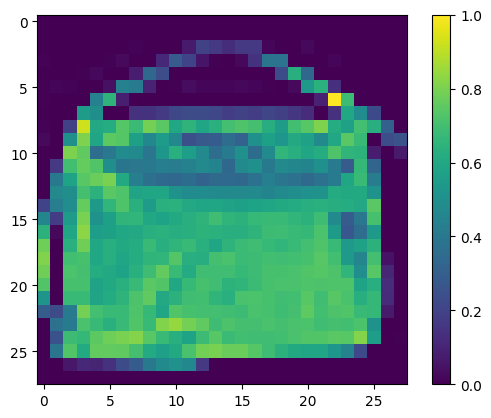

Class: Bag


In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()
print("Class:", class_names[label[0]])

In [ ]:
# Hide outputs
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2023-09-18 18:54:02--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2023-09-18 18:54:02--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl’

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.01s   

2023-09-18 18:54:02 (30.5 MB/s) - ‘fasionmnist_mlp_params.p

In [ ]:
def numpy_mlp(data, w0, b0, w1, b1):
    lv0 = data @ w0.T + b0
    lv1 = np.maximum(lv0, 0)
    lv2 = lv1 @ w1.T + b1
    return lv2

In [ ]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
res = numpy_mlp(img.reshape(1, 784),
                mlp_params["w0"],
                mlp_params["b0"],
                mlp_params["w1"],
                mlp_params["b1"])
print(res)
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("NumPy-MLP Prediction:", class_names[pred_kind[0]])

[[-36.13299   -47.72502    -9.275949  -18.921837   -7.161888   -9.535042
   -9.7998495 -30.950085   29.353281  -22.556564 ]]
[8]
NumPy-MLP Prediction: Bag


#### Optimization
1. Graph-Level Optimization: TVM starts with optimizations at the computation graph level. It takes the imported PyTorch model and tries to simplify its computational graph. This involves fusing nodes, eliminating redundancies, and reordering operations.

2. Layout Transformation: The layout of the tensors (NCHW, NHWC, etc.) can be changed to best suit the hardware. Different layouts can have a significant impact on performance due to the access patterns of the memory.

3. Kernel Matching: TVM uses a library of optimized kernel implementations for common operations. It attempts to map the operations in the computational graph to these optimized kernels.

4. Quantization: If applicable, this is the stage where model weights and activations may be quantized to lower precision formats like INT8 to reduce model size and increase inference speed.



- ![Alt Text](https://www.researchgate.net/publication/348753417/figure/fig6/AS:984105013497856@1611640327149/An-example-of-blocks-for-scheduling-optimization-with-their-corresponding-scheduling.png)

- ![Alt Text](https://www.allaboutcircuits.com/uploads/articles/qc-tech_quantization_gif-2_final.jpg)

- ![Alt Text](https://www.allaboutcircuits.com/uploads/articles/neuron_connections_quantization.jpg)

- ![Alt Text](https://tvm.apache.org/images/intro-auto-scheduler/search_overview.png)

- ![Alt Text](https://www.nvidia.com/content/dam/en-zz/Solutions/glossary/data-science/xgboost/img-3.png)

#### Partitioning
1. Dependency Analysis: TVM analyzes the computation graph to identify dependencies between nodes. The goal is to break the graph into independent subgraphs that can be executed in parallel or loaded separately.

2. Shard Formation: Once dependencies are mapped, the graph is divided into smaller segments, each forming a "shard". These shards are designed such that each can be loaded and executed independently of the others as much as possible.

3. Metadata Creation: Metadata is generated for each shard, specifying its dependencies, the sequence in which it should be executed, and other information that will be necessary for loading and running the shard.

4. Shard Optimization: After partitioning, each shard is subject to another round of optimization. This is because breaking the graph can sometimes introduce inefficiencies, like redundant operations that were previously fused.

- ![Alt Text](https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fs43588-021-00119-7/MediaObjects/43588_2021_119_Fig1_HTML.png)


#### Code Generation

1. Backend Selection: TVM allows you to specify the target backend, such as Vulkan for Android or Metal for iOS. Depending on this choice, different code generation pathways may be used.

2. Lowering: The high-level operations in each shard are transformed into low-level, hardware-specific instructions. This is often referred to as "lowering" the computation graph.

3. Compilation: Once the operations have been lowered, they are compiled into machine code optimized for the target architecture. This code is what will actually be run on the mobile device.

4. Packaging: Finally, the compiled machine code for each shard is packaged into a binary file format (.so for Android, .dylib for iOS, etc.). These binary files are now ready for deployment.

In [ ]:
from tvm.script import ir as I
from tvm.script import tir as T
from tvm.script import relax as R
#seperate computation and allocation

@I.ir_module
class Module:
    @T.prim_func
    def linear0(x: T.handle, w: T.handle, b: T.handle, z: T.handle):
        m = T.int64()
        X = T.match_buffer(x, (1, m))
        n = T.int64()
        W = T.match_buffer(w, (n, m))
        B = T.match_buffer(b, (n,))
        Z = T.match_buffer(z, (1, n))
        # with T.block("root"):
        Y = T.alloc_buffer((1, n))
        for i, j, k in T.grid(1, n, m):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, n):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @T.prim_func
    def relu0(x: T.handle, y: T.handle):
        n = T.int64()
        X = T.match_buffer(x, (1, n))
        Y = T.match_buffer(y, (1, n))
        # with T.block("root"):
        for i, j in T.grid(1, n):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(X[vi, vj])
                T.writes(Y[vi, vj])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @R.function
    def main(x: R.Tensor((1, "m"), dtype="float32"), w0: R.Tensor(("n", "m"), dtype="float32"), b0: R.Tensor(("n",), dtype="float32"), w1: R.Tensor(("k", "n"), dtype="float32"), b1: R.Tensor(("k",), dtype="float32")) -> R.Tensor((1, "k"), dtype="float32"):
        k = T.int64()
        m = T.int64()
        n = T.int64()
        with R.dataflow():
            lv0 = R.call_dps_packed("linear0", (x, w0, b0), out_sinfo=R.Tensor((1, n), dtype="float32"))
            lv1 = R.call_dps_packed("relu0", (lv0,), out_sinfo=R.Tensor((1, n), dtype="float32"))
            out = R.call_dps_packed("linear0", (lv1, w1, b1), out_sinfo=R.Tensor((1, k), dtype="float32"))
            R.output(out)
        return out

In [ ]:
ex = relax.build(MyModule, target="llvm")
type(ex)

In [ ]:
vm = relax.VirtualMachine(ex, tvm.cpu())

In [ ]:
data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

In [ ]:
nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])
print(nd_res)

In [ ]:
pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModule Prediction:", class_names[pred_kind[0]])

## Step 6 - Compile a Large Language Model from HuggingFace to iOS & Android with TVM
- MLC LLM https://mlc.ai/mlc-llm/docs/install/tvm.html

## Step 7 - Future Directions



## Dr Dignity Next Steps

1. Port RWKV 3B to an Android APK
2. Fine-tune Marx_3B on medical data to pass the US Medical Licensing Exam (i'm calling it MedMarx_3b)
3. Port MedMarx_3b to an Android APK
4. Fine-Tune MedMarx_3B on code dataset (CodeMedMarx_3B)
5. Port CodeMedMarx_3B to an Android APK as a Code Interpreter
6. Use the Code Interpreter as a retrieval system on a local medical datastore to cite sources
7. Fine-Tune CodeMedMarx_3B on biomedical image dataset for multimodal QA
8. Continue Fine-tuning on all modalities of biomedical data
9. Port MultiModalCodeMedMarx_3B to an Android APK
10. Build Local Video Avatar Interface for MultiModalCodeMedMarx_3B

The goal is to continually improve Dr Dignity's response accuracy until it replaces the need for human Doctors.




### Summary:

Option 1: Learn Vulkan for Android and Learn Metal for iOS
- Implement Android GPU Inference code in Vulkan
- Implement iOS GPU Inference code in Metal

(Better) Option 2: Learn Tensor Virtual Machine for iOS and Android
- Implement Cross Platform GPU inference code in Relay
- Optimize Relay code for Android or iOS
- Compile Relay code to Android or iOS



